#### Frederico Curti

In [43]:

%matplotlib inline
import cv2 as cv
import numpy as np
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import time
import random
import imutils
import math
import pickle
import os
import time
from pprint import pprint
from codeword import Codeword
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

print(cv.__version__)

3.4.2


/Users/fredcurti/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/fredcurti/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/fredcurti/.virtualenvs/jupyter/lib/python3.7/site-packages/traitlets/config/application.py", line 6

### Load training images

In [52]:
bg_images = []
view_folder = './samples/Crowd_PETS09 2/S0/Background/View_001'
folders = sorted(os.listdir(view_folder))
samples_per_folder = 5
for f in folders[1:]:
    p = f'{view_folder}/{f}'
    imgs = os.listdir(p)
    imgs = [f'{p}/{random.choice(imgs)}' for n in range(samples_per_folder)]
    bg_images.extend(imgs)
    
bg_images

['./samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-06/00000418.jpg',
 './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-06/00000120.jpg',
 './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-06/00000237.jpg',
 './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-06/00000357.jpg',
 './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-06/00000067.jpg',
 './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-19/00000368.jpg',
 './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-19/00000397.jpg',
 './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-19/00000279.jpg',
 './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-19/00000156.jpg',
 './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-19/00000284.jpg',
 './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-32/00000033.jpg',
 './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-32/00000128.jpg',
 './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-32/00000018.jpg',
 './samples/

In [45]:
# Prepare the codebook array for each pixel

def create_empty_codebooks(img):
    rows, cols = img.shape[:2]
    codebooks = []
    for i in range(rows):
        codebooks.append([])
        for j in range(cols):
            codebooks[i].append([])
    return codebooks

**TRAIN MODEL FROM IMAGES AND STORE TO PICKLE - SKIP IF TRAINED**

In [7]:

starting_img = cv.imread(random.choice(bg_images))
codebooks = create_empty_codebooks(starting_img)

# PARAMS
epsilon = 12
alpha = 0.5 # (0.4<=alpha<=0.7) - less means larger brightness bounds
beta = 1.4 # (1.1<=beta<=1.5) - used for limiting I_high

print(bg_images)

for t in range(len(bg_images)):
    start_time = time.time()
    img_path = bg_images[t]
    img = cv.imread(img_path)
    match_count = 0
    rows, cols = img.shape[:2]
    print(f'---- started reading image {t+1} {bg_images[t]} ----')
    for i in range(rows):
        for j in range(cols):
            # get current pixel and codebook for that pixel
            pixel = img[i][j].astype(float)
            pixel_codebook = codebooks[i][j]
            # calculate I (brightness) for the pixel
            I = math.sqrt(pixel[0]**2 + pixel[1]**2 + pixel[2]**2)
            matched = False
            k = 0
            while not matched and k < len(pixel_codebook):
                cw = pixel_codebook[k]
                # BRIGHTNESS AND COLORDIST
                xt2 = pixel[0]**2 + pixel[1]**2 + pixel[2]**2
                vi2 = cw[0][0]**2 + cw[0][1]**2 + cw[0][2]**2 
                xtvi2 = (cw[0][0]*pixel[0] + cw[0][1]*pixel[1] + cw[0][2]*pixel[2])**2
                p2 = xtvi2/vi2
                sigma = math.sqrt(abs(xt2 - p2)) # colordist
                
                I_low = alpha*cw[2]
                I_high = min(beta*cw[2], cw[1]/alpha)
                xt = math.sqrt(pixel[0]**2 + pixel[1]**2 + pixel[2]**2)
                
                if (sigma <= epsilon) and (I_low <= xt <= I_high):
                    matched = True
                    match_count += 1
                    # update codeword
                    cw[0] = ((cw[3]*cw[0]) + pixel) / (cw[3] + 1)
                    cw[1] = max(I, cw[1])
                    cw[2] = max(I, cw[2])
                    cw[3] += 1
                    cw[4] = max(cw[4], t - cw[6])
                    cw[5] = cw[5]
                    cw[6] = t
                k += 1 
                
            if matched == False:
                pixel_codebook.append([pixel, I, I, 1, t - 1, t, t])
                
    end_time = time.time()
    print(f'matches: {match_count} matches for img {t}')
    print(f'took {end_time - start_time}s')

rows, cols = img.shape[:2]
N = len(bg_images)
for i in range(rows):
    for j in range(cols):
        for cw in codebooks[i][j]:
            cw[4] = max(cw[4], (N - cw[6] + cw[5] - 1))
            
pickle.dump(codebooks, open("training.p", "wb"))
print("Saved training to training.p")

['./samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-06/00000119.jpg', './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-06/00000386.jpg', './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-06/00000214.jpg', './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-06/00000173.jpg', './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-06/00000133.jpg', './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-19/00000163.jpg', './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-19/00000043.jpg', './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-19/00000019.jpg', './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-19/00000376.jpg', './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-19/00000223.jpg', './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-32/00000260.jpg', './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-32/00000207.jpg', './samples/Crowd_PETS09 2/S0/Background/View_001/Time_13-32/00000190.jpg', './samples/Crowd_PETS09 

KeyboardInterrupt: 

**LOAD TRAINING FROM PICKLE**

In [46]:
training = pickle.load(open("training.p", "rb"))

**BACKGROUND SUBTRACTION**

In [47]:
def subtractBG_single_image(img, epsilon = 12, alpha = 0.4, beta = 1.1):
    for i in range(len(training)):
        for j in range(len(training[0])):
            pixel = img[i][j].astype(float)
            pixel_codebook = training[i][j]
            I = math.sqrt(pixel[0]**2 + pixel[1]**2 + pixel[2]**2)
            matched = False
            k = 0
            while not matched and k < len(pixel_codebook):
                cw = pixel_codebook[k]
                # BRIGHTNESS AND COLORDIST
                xt2 = pixel[0]**2 + pixel[1]**2 + pixel[2]**2
                vi2 = cw[0][0]**2 + cw[0][1]**2 + cw[0][2]**2 
                xtvi2 = (cw[0][0]*pixel[0] + cw[0][1]*pixel[1] + cw[0][2]*pixel[2])**2
                p2 = xtvi2/vi2
                sigma = math.sqrt(abs(xt2 - p2)) # colordist

                I_low = alpha*cw[2]
                I_high = min(beta*cw[2], cw[1]/alpha)
                xt = math.sqrt(pixel[0]**2 + pixel[1]**2 + pixel[2]**2)

                if (sigma <= epsilon) and (I_low <= xt <= I_high):
                    matched = True
                    break
                k +=1

            if matched == False:
                img[i][j] = [255, 255, 255]
            else:
                img[i][j] = [0,0,0]
    
    print(f'------ alpha:{alpha} beta:{beta} epsilon:{epsilon}')
    plt.imshow(img)
    plt.show()
    print('---------------------------------------------------\n')
    return img

### Subtract - Params testing (DO NOT RUN)

/Users/fredcurti/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/fredcurti/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/fredcurti/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/fredcurti/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/fredcurti/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/fredcurti/.virtualenvs/jupyt

------ alpha:0.4 beta:1.1 epsilon:32
------ alpha:0.4 beta:1.1 epsilon:36


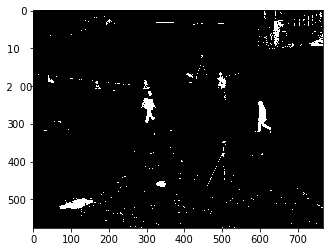

---------------------------------------------------



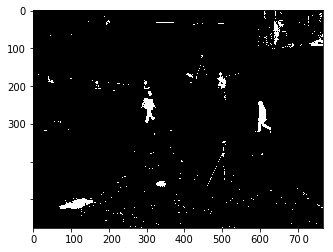

---------------------------------------------------

------ alpha:0.4 beta:1.1 epsilon:28


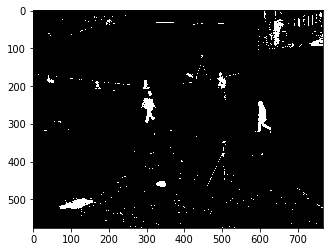

---------------------------------------------------

------ alpha:0.4 beta:1.1 epsilon:24


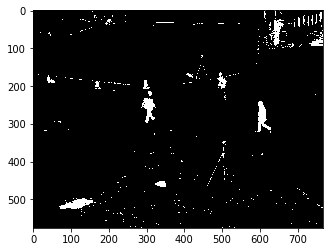

---------------------------------------------------

------ alpha:0.4 beta:1.1 epsilon:20


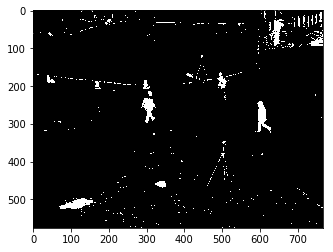

---------------------------------------------------

------ alpha:0.4 beta:1.1 epsilon:16


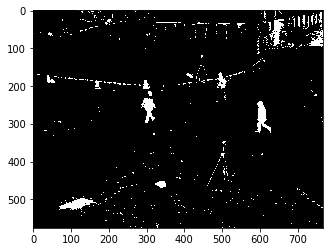

---------------------------------------------------

------ alpha:0.4 beta:1.1 epsilon:12
------ alpha:0.4 beta:1.2 epsilon:12


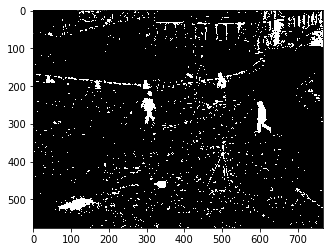

---------------------------------------------------



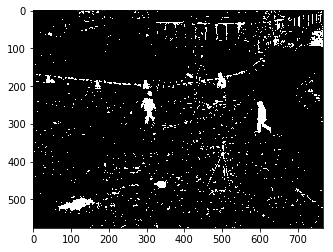

---------------------------------------------------



KeyboardInterrupt: 

------ alpha:0.4 beta:1.3 epsilon:36
------ alpha:0.4 beta:1.3 epsilon:32


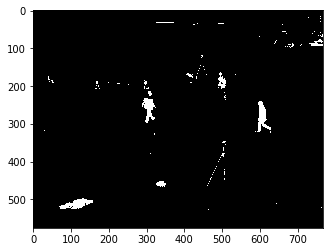

---------------------------------------------------



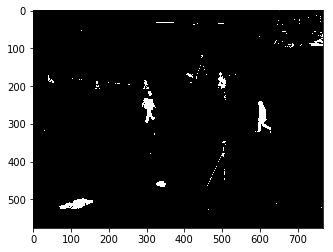

---------------------------------------------------

------ alpha:0.4 beta:1.3 epsilon:28


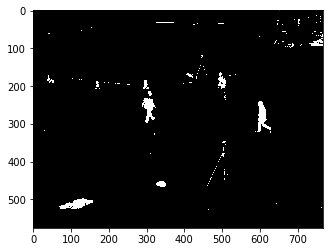

---------------------------------------------------

------ alpha:0.4 beta:1.3 epsilon:24


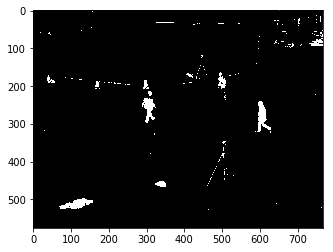

---------------------------------------------------

------ alpha:0.4 beta:1.3 epsilon:20
------ alpha:0.4 beta:1.4 epsilon:20


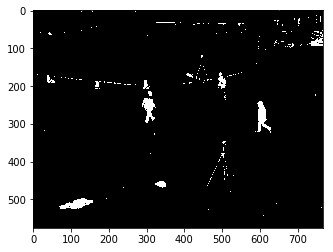

---------------------------------------------------



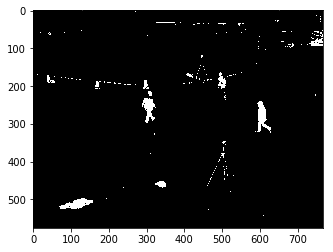

---------------------------------------------------

------ alpha:0.4 beta:1.4 epsilon:16
------ alpha:0.4 beta:1.4 epsilon:12


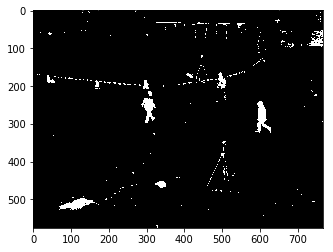

---------------------------------------------------



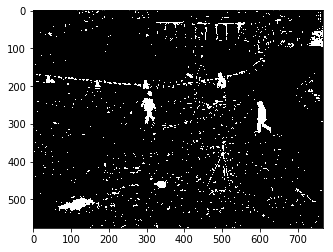

---------------------------------------------------

------ alpha:0.4 beta:1.4 epsilon:28
------ alpha:0.4 beta:1.4 epsilon:32
------ alpha:0.4 beta:1.4 epsilon:36


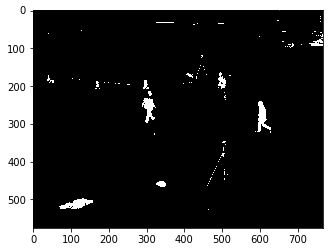

---------------------------------------------------



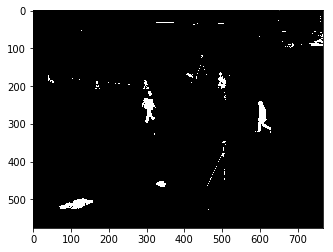

---------------------------------------------------



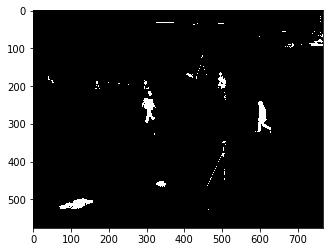

---------------------------------------------------

------ alpha:0.4 beta:1.4 epsilon:24


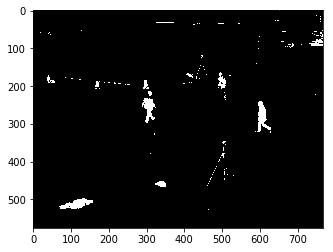

---------------------------------------------------

------ alpha:0.4 beta:1.5 epsilon:16
------ alpha:0.4 beta:1.5 epsilon:24


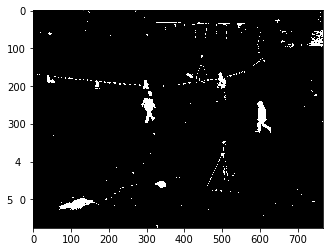

---------------------------------------------------


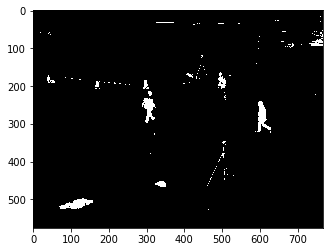


---------------------------------------------------

------ alpha:0.4 beta:1.5 epsilon:20
------ alpha:0.4 beta:1.5 epsilon:12


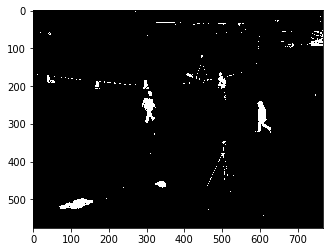

---------------------------------------------------



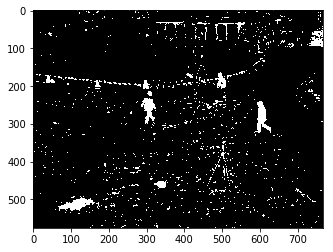

---------------------------------------------------

------ alpha:0.4 beta:1.5 epsilon:36


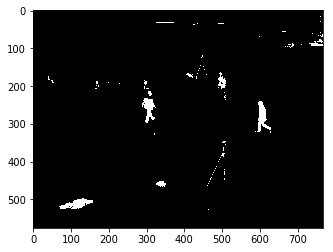

---------------------------------------------------

------ alpha:0.4 beta:1.5 epsilon:32


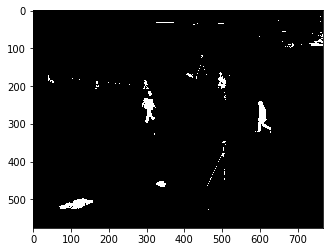

---------------------------------------------------

------ alpha:0.4 beta:1.5 epsilon:28


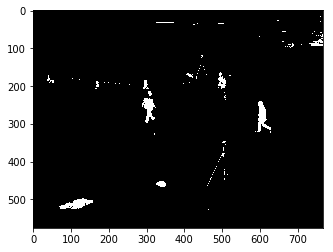

---------------------------------------------------

------ alpha:0.5 beta:1.1 epsilon:12


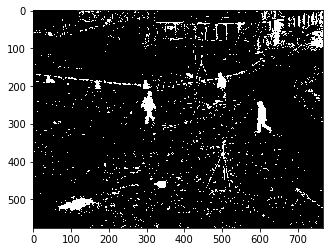

---------------------------------------------------

------ alpha:0.5 beta:1.1 epsilon:28


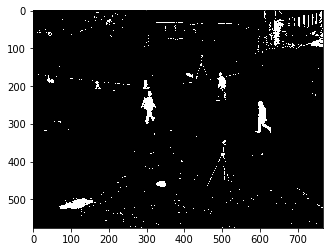

---------------------------------------------------

------ alpha:0.5 beta:1.1 epsilon:24
------ alpha:0.5 beta:1.1 epsilon:20


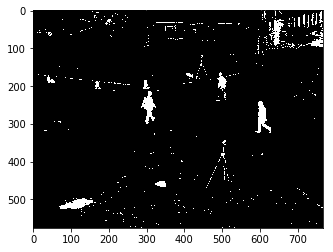

---------------------------------------------------



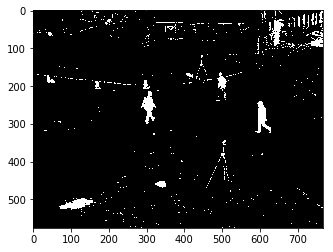

---------------------------------------------------

------ alpha:0.5 beta:1.1 epsilon:16


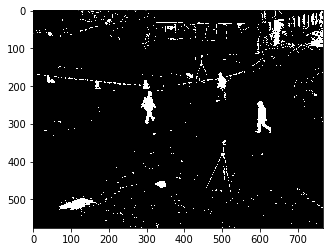

---------------------------------------------------

------ alpha:0.5 beta:1.1 epsilon:32


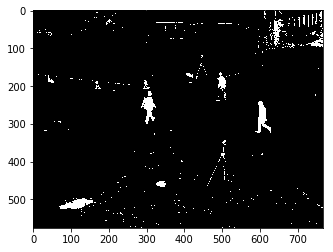

---------------------------------------------------

------ alpha:0.5 beta:1.1 epsilon:36


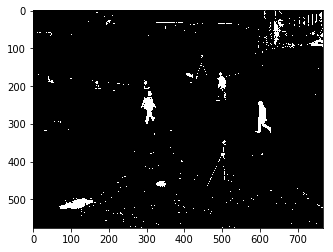

---------------------------------------------------

------ alpha:0.5 beta:1.2 epsilon:12


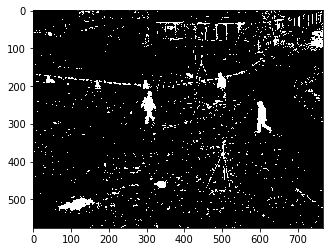

---------------------------------------------------

------ alpha:0.5 beta:1.2 epsilon:16


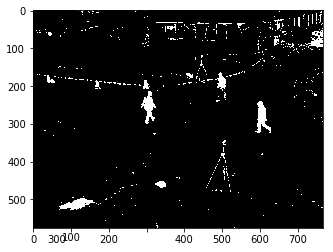

---------------------------------------------------

------ alpha:0.5 beta:1.2 epsilon:32
------ alpha:0.5 beta:1.2 epsilon:28


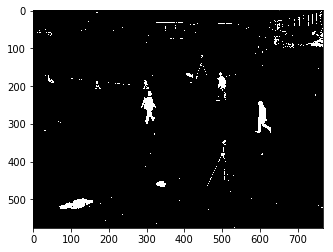

---------------------------------------------------



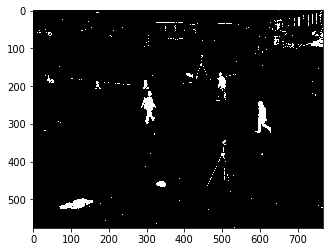

---------------------------------------------------

------ alpha:0.5 beta:1.2 epsilon:20
------ alpha:0.5 beta:1.2 epsilon:24


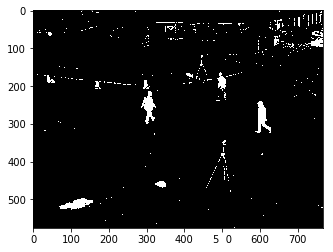

---------------------------------------------------



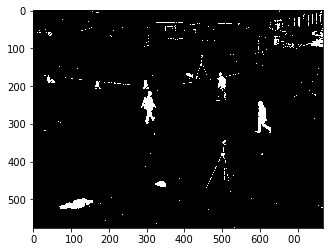

---------------------------------------------------

------ alpha:0.5 beta:1.2 epsilon:36


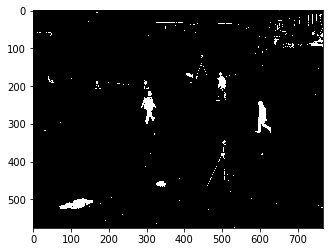

---------------------------------------------------

------ alpha:0.5 beta:1.3 epsilon:12


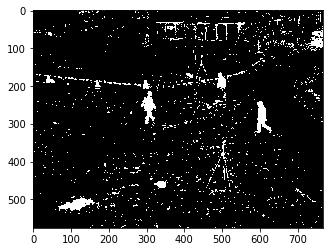

---------------------------------------------------

------ alpha:0.5 beta:1.3 epsilon:16


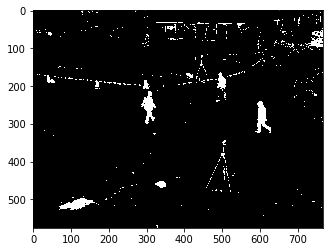

---------------------------------------------------

------ alpha:0.5 beta:1.3 epsilon:36


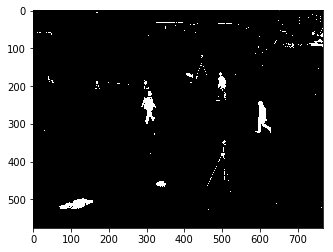

---------------------------------------------------

------ alpha:0.5 beta:1.3 epsilon:32
------ alpha:0.5 beta:1.3 epsilon:28



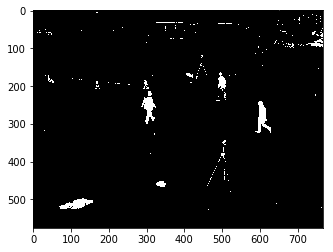

---------------------------------------------------


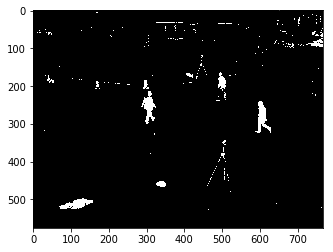

---------------------------------------------------

------ alpha:0.5 beta:1.3 epsilon:24
------ alpha:0.5 beta:1.3 epsilon:20


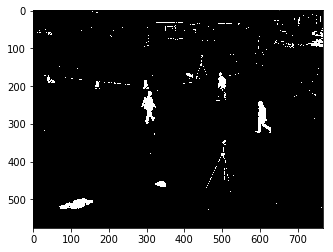

---------------------------------------------------



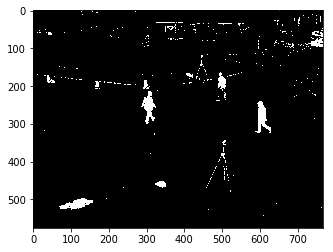

---------------------------------------------------

------ alpha:0.5 beta:1.4 epsilon:12


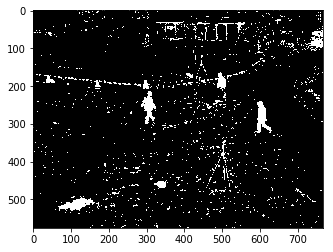

---------------------------------------------------

------ alpha:0.5 beta:1.4 epsilon:16


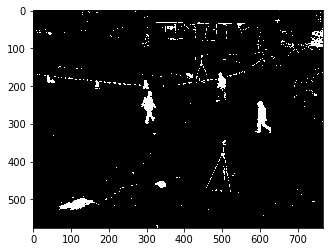

---------------------------------------------------

------ alpha:0.5 beta:1.4 epsilon:36


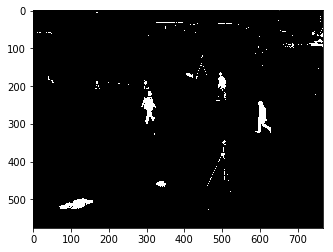

---------------------------------------------------

------ alpha:0.5 beta:1.4 epsilon:32
------ alpha:0.5 beta:1.4 epsilon:20


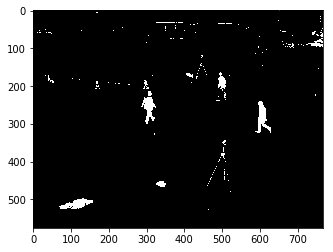

---------------------------------------------------



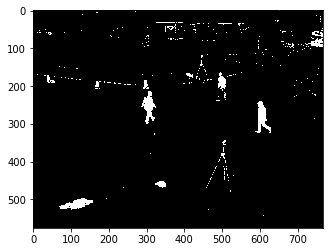

---------------------------------------------------

------ alpha:0.5 beta:1.4 epsilon:24
------ alpha:0.5 beta:1.4 epsilon:28


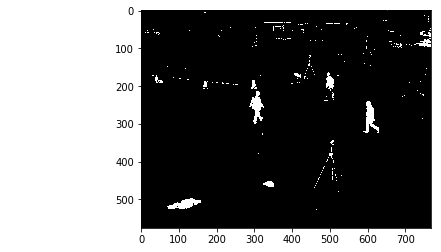

---------------------------------------------------



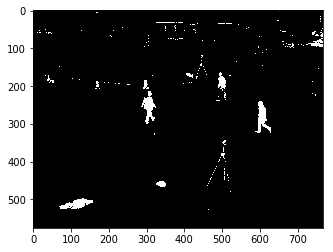

---------------------------------------------------

------ alpha:0.5 beta:1.5 epsilon:12


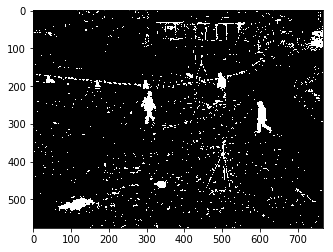

---------------------------------------------------

------ alpha:0.5 beta:1.5 epsilon:16


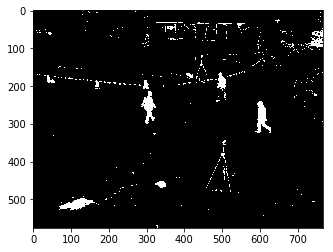

---------------------------------------------------

------ alpha:0.5 beta:1.5 epsilon:20


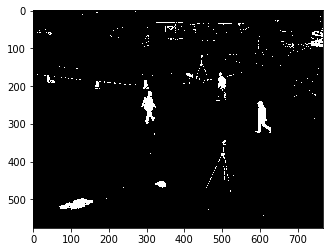

---------------------------------------------------

------ alpha:0.5 beta:1.5 epsilon:36


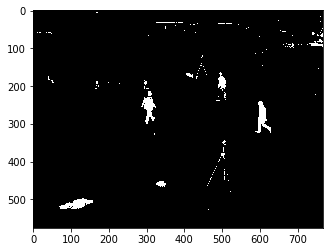

---------------------------------------------------

------ alpha:0.5 beta:1.5 epsilon:32


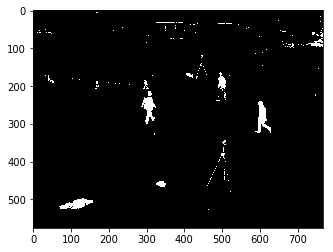

---------------------------------------------------

------ alpha:0.5 beta:1.5 epsilon:28


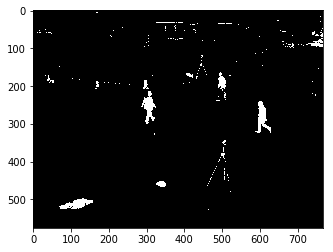

---------------------------------------------------

------ alpha:0.5 beta:1.5 epsilon:24


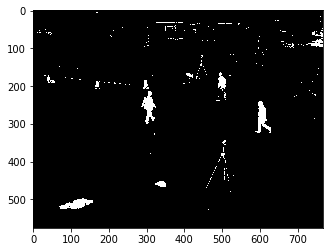

---------------------------------------------------

------ alpha:0.6 beta:1.1 epsilon:12


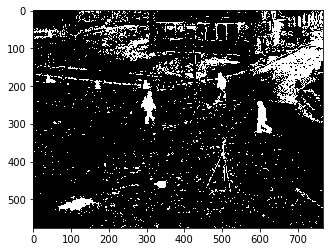

---------------------------------------------------

------ alpha:0.6 beta:1.1 epsilon:16


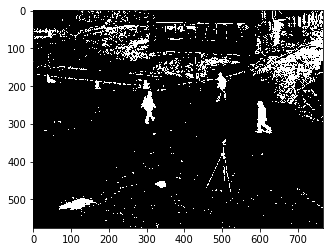

---------------------------------------------------

------ alpha:0.6 beta:1.1 epsilon:20


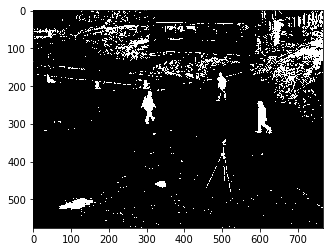

---------------------------------------------------

------ alpha:0.6 beta:1.1 epsilon:36
------ alpha:0.6 beta:1.1 epsilon:32
------ alpha:0.6 beta:1.1 epsilon:24


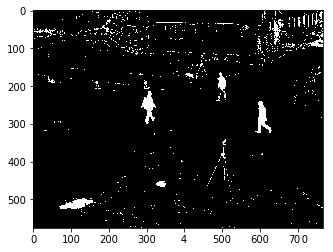

---------------------------------------------------

------ alpha:0.6 beta:1.1 epsilon:28


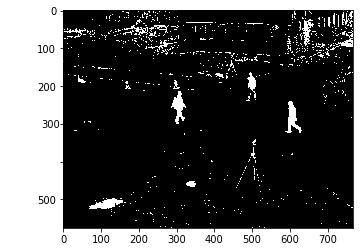

---------------------------------------------------



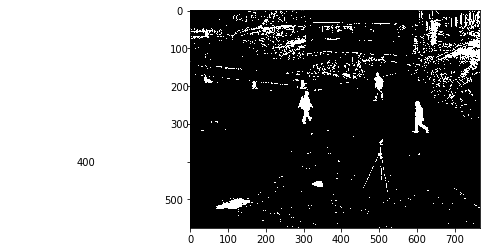

---------------------------------------------------



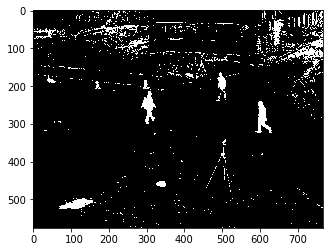

---------------------------------------------------

------ alpha:0.6 beta:1.2 epsilon:12


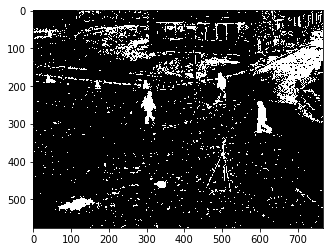

---------------------------------------------------

------ alpha:0.6 beta:1.2 epsilon:16


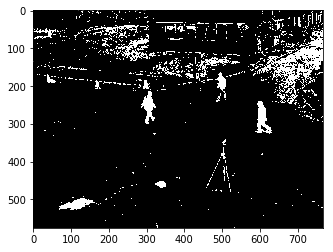

---------------------------------------------------

------ alpha:0.6 beta:1.2 epsilon:20


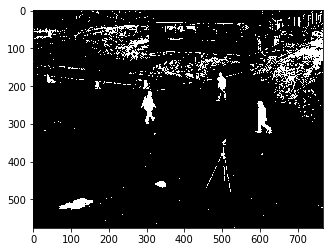

---------------------------------------------------

------ alpha:0.6 beta:1.2 epsilon:24


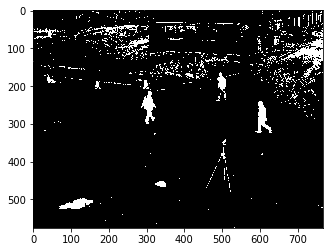

---------------------------------------------------

------ alpha:0.6 beta:1.2 epsilon:36


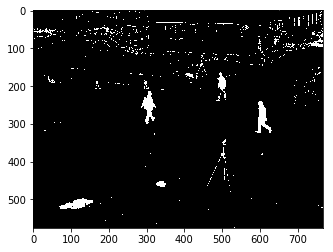

---------------------------------------------------

------ alpha:0.6 beta:1.2 epsilon:32


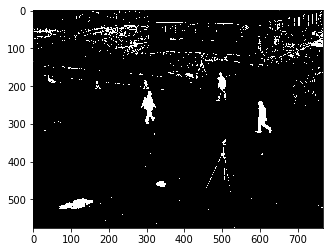

---------------------------------------------------

------ alpha:0.6 beta:1.2 epsilon:28


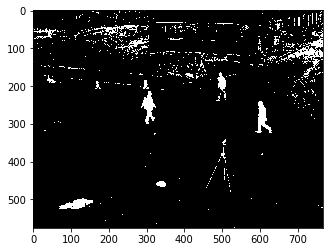

---------------------------------------------------

------ alpha:0.6 beta:1.3 epsilon:12


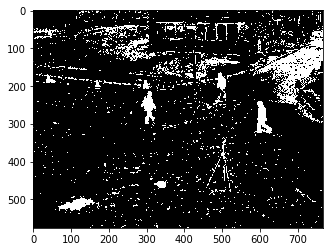

---------------------------------------------------

------ alpha:0.6 beta:1.3 epsilon:16


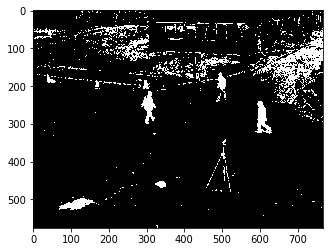

---------------------------------------------------

------ alpha:0.6 beta:1.3 epsilon:20


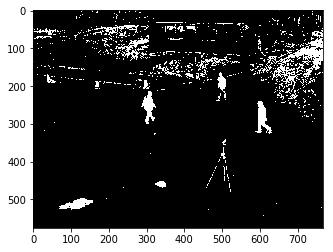

---------------------------------------------------

------ alpha:0.6 beta:1.3 epsilon:24


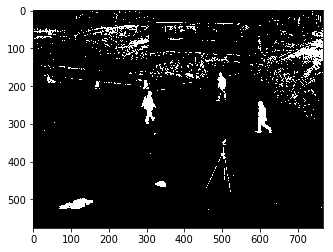

---------------------------------------------------

------ alpha:0.6 beta:1.3 epsilon:28
------ alpha:0.6 beta:1.3 epsilon:36
------ alpha:0.6 beta:1.3 epsilon:32


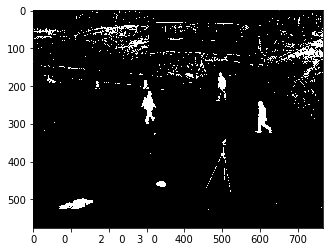

---------------------------------------------------



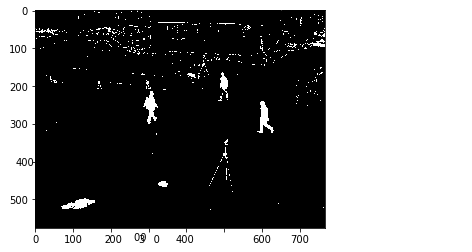

---------------------------------------------------



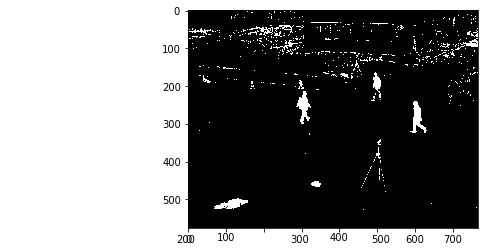

---------------------------------------------------

------ alpha:0.6 beta:1.4 epsilon:12


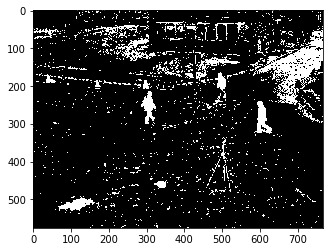

---------------------------------------------------

------ alpha:0.6 beta:1.4 epsilon:16


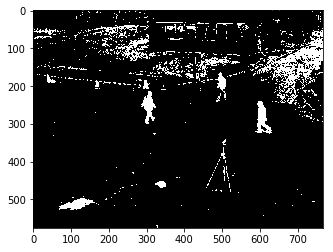

---------------------------------------------------

------ alpha:0.6 beta:1.4 epsilon:20


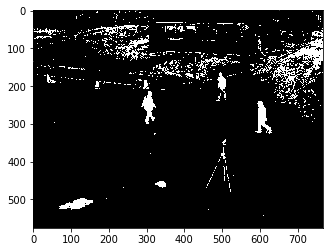

---------------------------------------------------

------ alpha:0.6 beta:1.4 epsilon:24


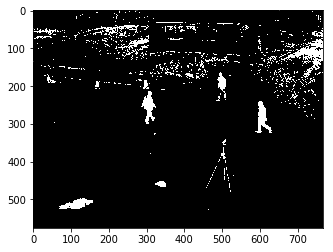

---------------------------------------------------

------ alpha:0.6 beta:1.4 epsilon:28


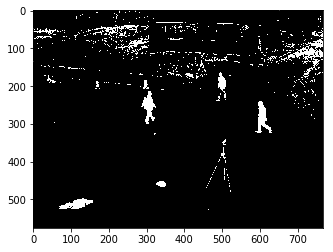

---------------------------------------------------

------ alpha:0.6 beta:1.4 epsilon:36


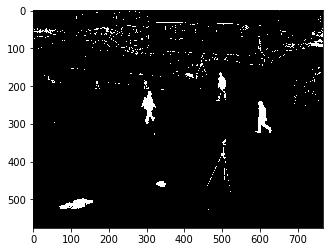

---------------------------------------------------

------ alpha:0.6 beta:1.4 epsilon:32


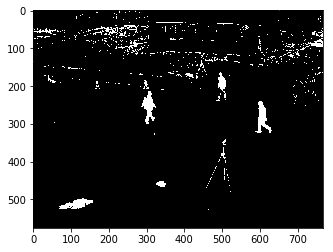

---------------------------------------------------

------ alpha:0.6 beta:1.5 epsilon:12


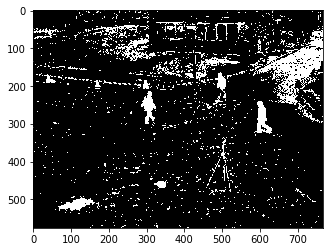

---------------------------------------------------

------ alpha:0.6 beta:1.5 epsilon:16


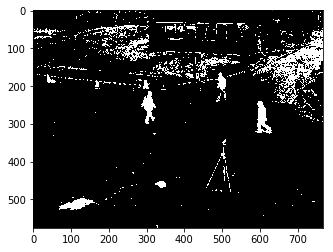

---------------------------------------------------

------ alpha:0.6 beta:1.5 epsilon:20


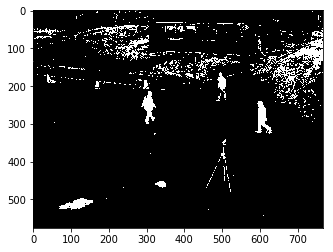

---------------------------------------------------

------ alpha:0.6 beta:1.5 epsilon:24


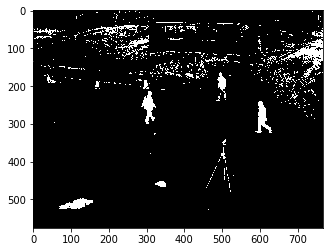

---------------------------------------------------

------ alpha:0.6 beta:1.5 epsilon:28
------ alpha:0.6 beta:1.5 epsilon:32


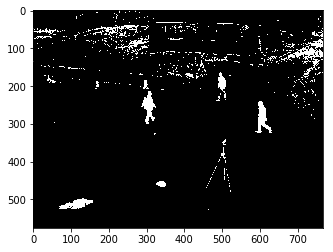

---------------------------------------------------



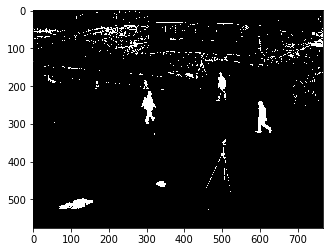

---------------------------------------------------

------ alpha:0.6 beta:1.5 epsilon:36


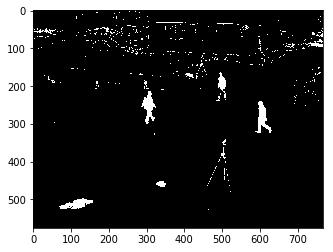

---------------------------------------------------

------ alpha:0.7 beta:1.1 epsilon:12


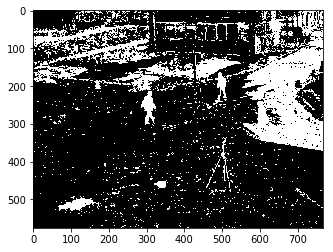

---------------------------------------------------

------ alpha:0.7 beta:1.1 epsilon:16


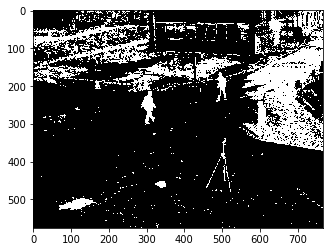

---------------------------------------------------

------ alpha:0.7 beta:1.1 epsilon:20


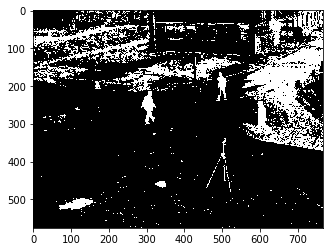

---------------------------------------------------

------ alpha:0.7 beta:1.1 epsilon:24


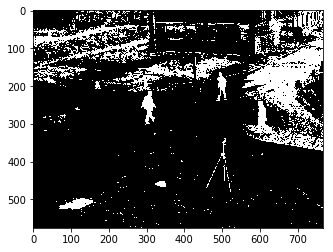

---------------------------------------------------

------ alpha:0.7 beta:1.1 epsilon:28
------ alpha:0.7 beta:1.1 epsilon:36


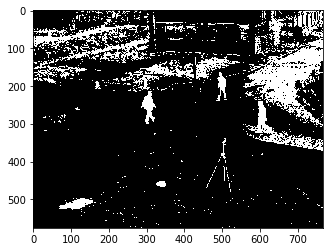

---------------------------------------------------



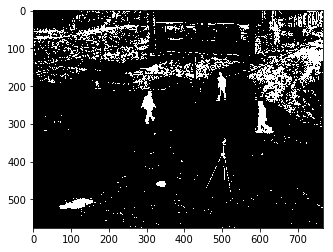

---------------------------------------------------

------ alpha:0.7 beta:1.1 epsilon:32


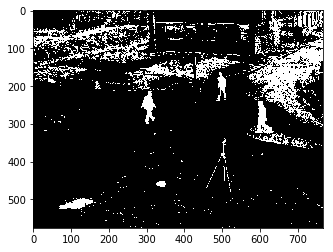

---------------------------------------------------

------ alpha:0.7 beta:1.2 epsilon:12


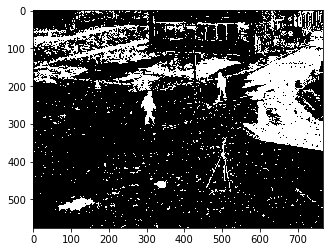

---------------------------------------------------

------ alpha:0.7 beta:1.2 epsilon:16


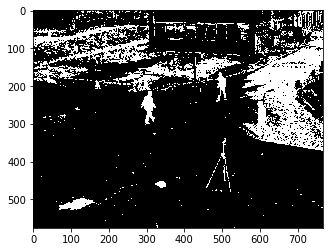

---------------------------------------------------

------ alpha:0.7 beta:1.2 epsilon:20


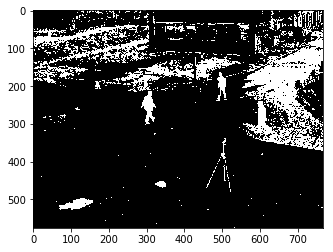

---------------------------------------------------

------ alpha:0.7 beta:1.2 epsilon:24


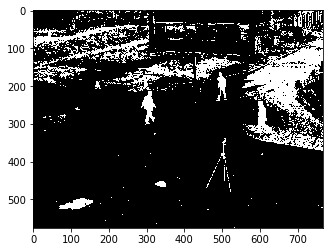

---------------------------------------------------

------ alpha:0.7 beta:1.2 epsilon:28


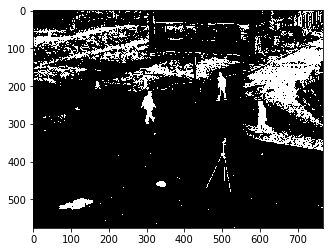

---------------------------------------------------

------ alpha:0.7 beta:1.2 epsilon:36


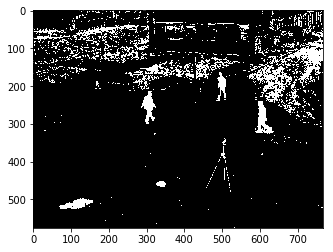

---------------------------------------------------

------ alpha:0.7 beta:1.2 epsilon:32


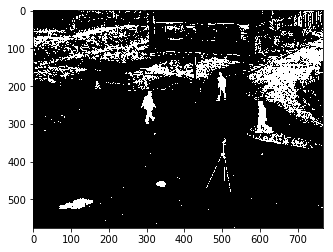

---------------------------------------------------

------ alpha:0.7 beta:1.3 epsilon:12


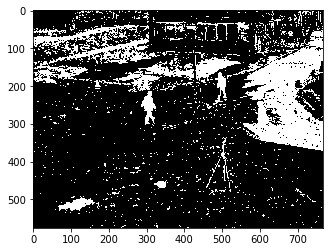

---------------------------------------------------

------ alpha:0.7 beta:1.3 epsilon:16


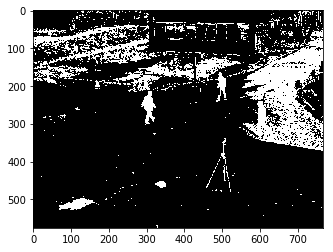

---------------------------------------------------

------ alpha:0.7 beta:1.3 epsilon:20


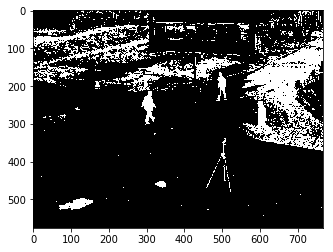

---------------------------------------------------

------ alpha:0.7 beta:1.3 epsilon:24


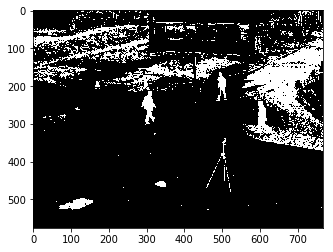

---------------------------------------------------

------ alpha:0.7 beta:1.3 epsilon:32
------ alpha:0.7 beta:1.3 epsilon:28
------ alpha:0.7 beta:1.3 epsilon:36


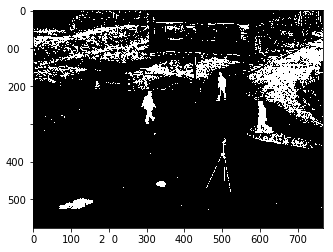

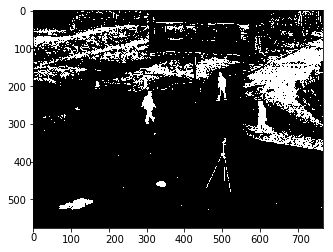

---------------------------------------------------
---------------------------------------------------




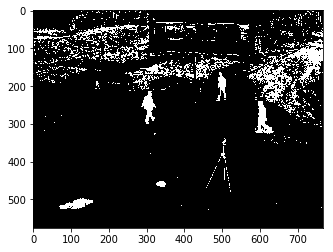

---------------------------------------------------

------ alpha:0.7 beta:1.4 epsilon:12


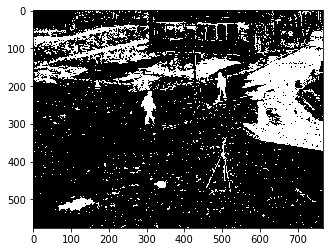

---------------------------------------------------

------ alpha:0.7 beta:1.4 epsilon:16


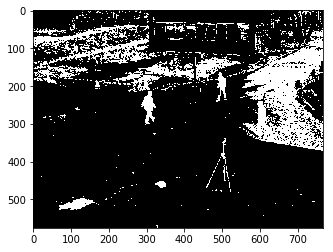

---------------------------------------------------

------ alpha:0.7 beta:1.4 epsilon:20


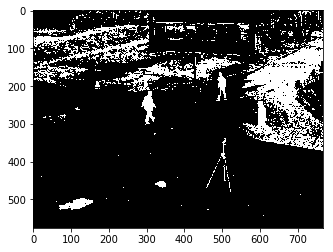

---------------------------------------------------

------ alpha:0.7 beta:1.4 epsilon:24


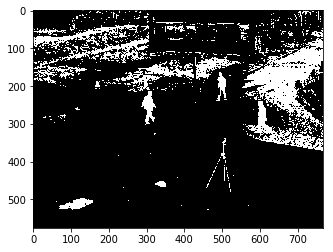

---------------------------------------------------

------ alpha:0.7 beta:1.4 epsilon:28


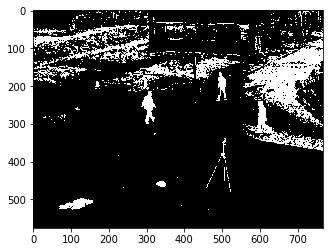

---------------------------------------------------

------ alpha:0.7 beta:1.4 epsilon:36


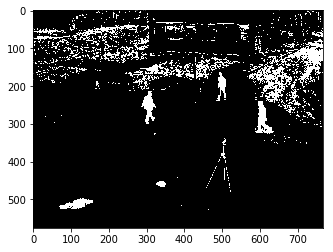

---------------------------------------------------

------ alpha:0.7 beta:1.4 epsilon:32


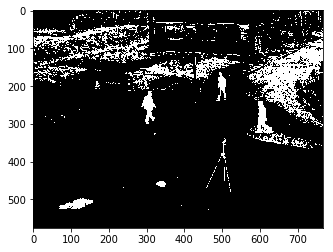

---------------------------------------------------

------ alpha:0.7 beta:1.5 epsilon:12


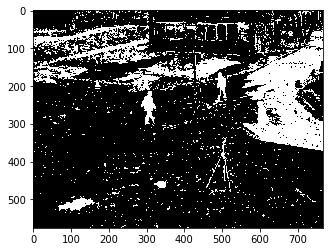

---------------------------------------------------

------ alpha:0.7 beta:1.5 epsilon:16


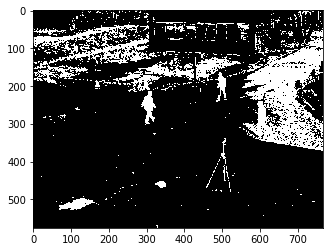

---------------------------------------------------

------ alpha:0.7 beta:1.5 epsilon:20


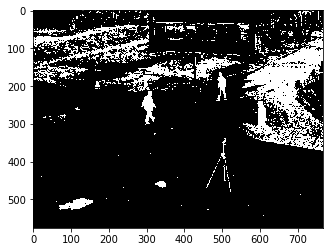

---------------------------------------------------

------ alpha:0.7 beta:1.5 epsilon:24


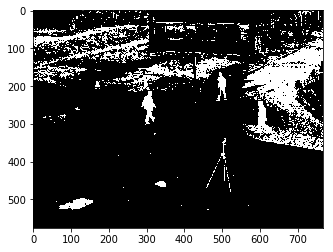

---------------------------------------------------

------ alpha:0.7 beta:1.5 epsilon:28


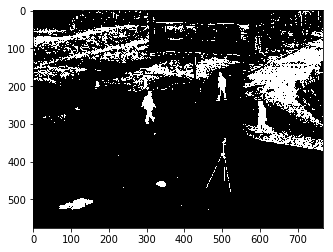

---------------------------------------------------

------ alpha:0.7 beta:1.5 epsilon:32


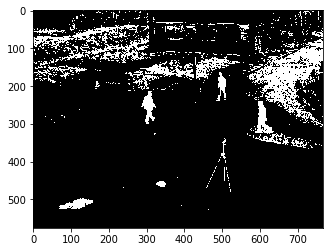

---------------------------------------------------

------ alpha:0.7 beta:1.5 epsilon:36


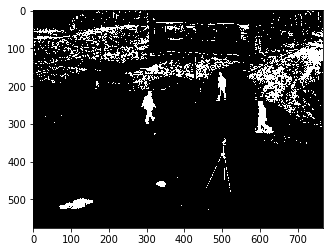

---------------------------------------------------



In [48]:
#(0.4<=alpha<=0.7) - less means larger brightness bounds
# (1.1<=beta<=1.5) - used for limiting I_high
alphas = [0.4, 0.5, 0.6, 0.7]
betas = [1.1, 1.2, 1.3, 1.4, 1.5]
epsilons = [12, 16, 20, 24, 28, 32, 36]

with ProcessPoolExecutor(max_workers=8) as ppe:
    for a in alphas:
        for b in betas:
            for e in epsilons:
                img_path = './Imagens/foreground01.jpg'
                img = cv.imread(img_path)
    #             RGB_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                ppe.submit(subtractBG_single_image, img, e, a, b)


### Dilate + Erode

In [49]:

def blur_dilate_and_erode(img):
    kernel = np.ones((6,6), np.uint8)
    blurred = cv.blur(img, (3,3))
    erosion = cv.erode(blurred, kernel, iterations = 1)
    result_img = cv.dilate(erosion, kernel, iterations = 2)
    return result_img

In [50]:
def get_blobs(img):
    params = cv.SimpleBlobDetector_Params()
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    d = 15
    
    params.filterByArea = True
    params.minArea = 3.14159 * d * d
    
    params.filterByColor = False
    params.filterByCircularity = False

    params.filterByConvexity = True
    params.minConvexity = 0.3
    
    params.filterByInertia = True
    params.maxInertiaRatio = 0.75
    
    params.minDistBetweenBlobs = 0


    detector = cv.SimpleBlobDetector_create(params)
    mask = 255 - np.uint8(img)
    keypoints = detector.detect(mask)
    img_with_circles = img.copy()
    
    for each in keypoints:
        pt = (int(each.pt[0]),int(each.pt[1]))
        cv.circle(img_with_circles, pt, int(each.size), (255,0,0), 3)

    plt.imshow(img_with_circles)
    
    return img_with_circles, len(keypoints), keypoints

### FG Extraction from sequence and counting

/Users/fredcurti/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


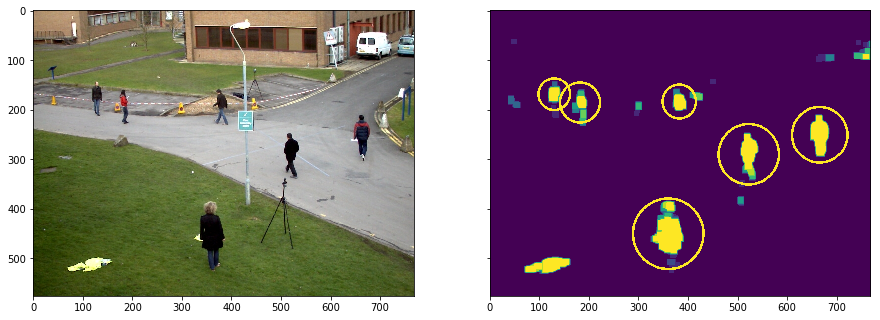

FOUND 6 PEOPLE
--- Done matching t:0


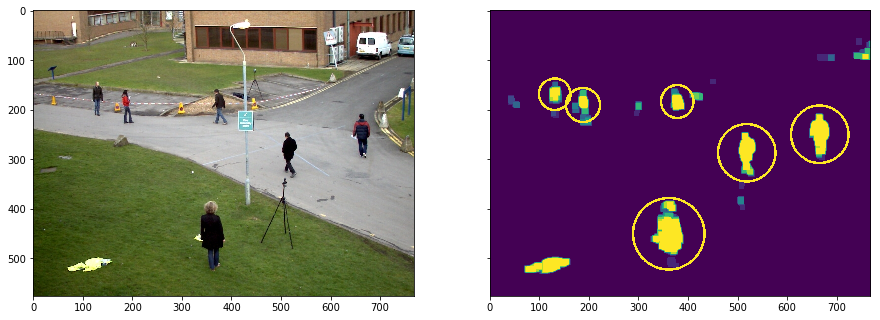

FOUND 6 PEOPLE
--- Done matching t:1


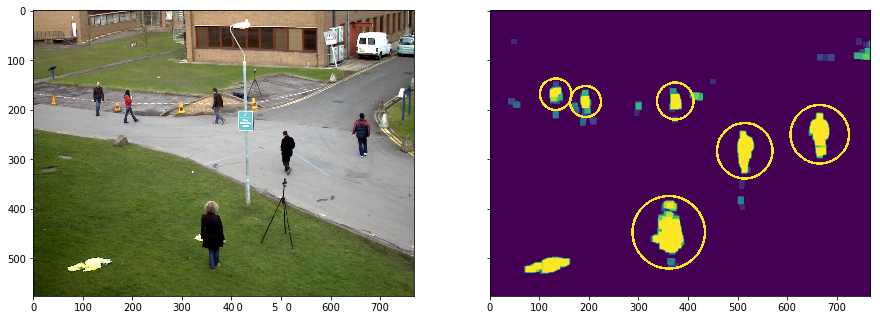

FOUND 6 PEOPLE
--- Done matching t:2


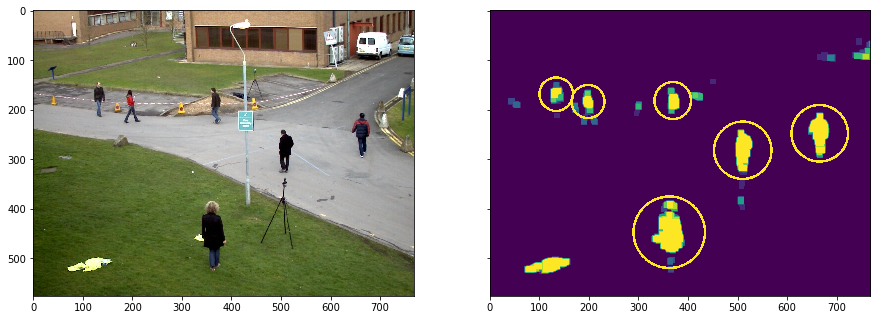

FOUND 6 PEOPLE
--- Done matching t:3


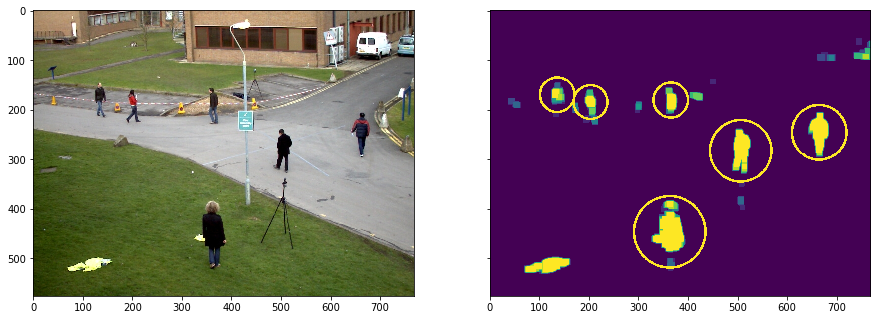

FOUND 6 PEOPLE
--- Done matching t:4


In [51]:
def subtractBG_set(img_set, epsilon = 12, alpha = 0.4, beta = 1.1):
    for t in range(len(img_set)):
        img = img_set[t]
        original = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        for i in range(len(training)):
            for j in range(len(training[0])):
                pixel = img[i][j].astype(float)
                pixel_codebook = training[i][j]
                I = math.sqrt(pixel[0]**2 + pixel[1]**2 + pixel[2]**2)
                matched = False
                k = 0
                while not matched and k < len(pixel_codebook):
                    cw = pixel_codebook[k]
                    # BRIGHTNESS AND COLORDIST
                    xt2 = pixel[0]**2 + pixel[1]**2 + pixel[2]**2
                    vi2 = cw[0][0]**2 + cw[0][1]**2 + cw[0][2]**2 
                    xtvi2 = (cw[0][0]*pixel[0] + cw[0][1]*pixel[1] + cw[0][2]*pixel[2])**2
                    p2 = xtvi2/vi2
                    sigma = math.sqrt(abs(xt2 - p2)) # colordist

                    I_low = alpha*cw[2]
                    I_high = min(beta*cw[2], cw[1]/alpha)
                    xt = math.sqrt(pixel[0]**2 + pixel[1]**2 + pixel[2]**2)

                    if (sigma <= epsilon) and (I_low <= xt <= I_high):
                        matched = True
                        # update codeword
                        cw[0] = ((cw[3]*cw[0]) + pixel) / (cw[3] + 1)
                        cw[1] = max(I, cw[1])
                        cw[2] = max(I, cw[2])
                        cw[3] += 1
                        cw[4] = max(cw[4], t - cw[6])
                        cw[5] = cw[5]
                        cw[6] = t
                    k +=1
                    
                if matched == False:
                    img[i][j] = [255, 255, 255]
                else:
                    img[i][j] = [0,0,0]
                    
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,6))
        bde = blur_dilate_and_erode(img)
        spotted_img, amount, keypoints = get_blobs(bde)
        ax1.imshow(original)
        ax2.imshow(spotted_img)
        plt.show()
        print('FOUND', amount, 'PEOPLE')
        print(f'--- Done matching t:{t}')

    return img, keypoints


fg_images = []
fg_path = 'samples/Crowd_PETS09 3/S0/City_Center/Time_12-34/View_001'
for fg_img_path in sorted(os.listdir(fg_path))[640:645]:
    fg_images.append(cv.imread(fg_path + '/' + fg_img_path))

img, keypoints = subtractBG_set(fg_images, alpha=0.5, beta=1.4,epsilon=32)